In [1]:
import networkx as nx
import matplotlib.pyplot as plt

class Graph:
    def __init__(self, n):
        self.adj_list = []
        self.num_vert = n
        self.vertices = list(range(n))

    def addEdge(self, a, b, w):
        t, l = (min(a,b), max(a,b))
        for i in range(len(self.adj_list)):
            if(self.adj_list[i][0] == t and self.adj_list[i][1] == l):
                self.adj_list[i][2] += w
                return
        self.adj_list.append([t, l, w])
    
    def consume_edge(self, edge):
        self.vertices.remove(edge[1])
        weight_dicts = {}
        delete_indices  = []
        edges = self.adj_list

        for i in range(len(self.adj_list)):
            if(edges[i][0] == edge[1] and edges[i][1] != edge[0]):
                if(edges[i][1] in weight_dicts.keys()):
                    weight_dicts[edges[i][1]] += edges[i][2]
                else:
                    weight_dicts[edges[i][1]] = edges[i][2]
                delete_indices.append(i)
            elif(edges[i][1] == edge[1] and edges[i][0] != edge[0]):
                if(edges[i][0] in weight_dicts.keys()):
                    weight_dicts[edges[i][0]] += edges[i][2]
                else:
                    weight_dicts[edges[i][0]] = edges[i][2]
                delete_indices.append(i)
            elif(edges[i][1] == edge[1] and edges[i][0] == edge[0]):
                delete_indices.append(i)
            else:
                pass
        
        delete_indices.sort(reverse=True)
        for x in delete_indices:
            del self.adj_list[x]

        for p in weight_dicts.keys():
            self.addEdge(edge[0], p, weight_dicts[p])
        
        self.num_vert = len(self.vertices)
    
    def get_heaviest_edge(self):
        sorted_edges = sorted(self.adj_list, key= lambda x: x[2], reverse=True)
        return sorted_edges[0] 
        

class GraphVisualizer:
    def __init__(self):
        self.G = nx.Graph()

    def addEdges(self, graph):
        for i in graph.adj_list:
            self.G.add_edge(i[0], i[1], weight=i[2])
        
    def visualize(self, text="Network Visualized"):
        pos = nx.planar_layout(self.G)
        nx.draw_networkx(self.G, pos)
        labels = nx.get_edge_attributes(self.G, 'weight')
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=labels)
        plt.title(text)
        plt.show()

###  An example of `consume_edge()`, where we consume the edge between 3-4

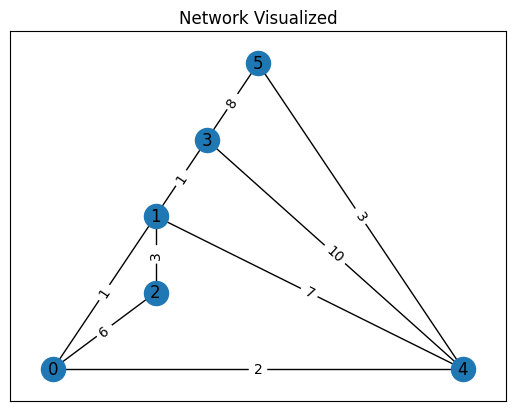

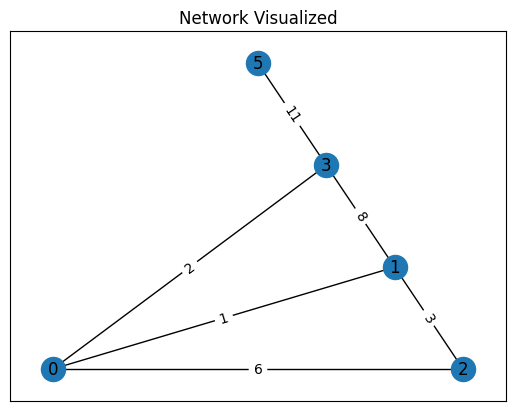

In [2]:
graph = Graph(6)
graph.addEdge(0, 2 ,6)
graph.addEdge(1, 3, 1)
graph.addEdge(1, 2, 3)
graph.addEdge(5, 3 ,8)
graph.addEdge(3, 4, 10)
graph.addEdge(1, 0, 1)
graph.addEdge(4, 5, 3)
graph.addEdge(4, 0, 2)
graph.addEdge(4, 1, 7)

v = GraphVisualizer()
v.addEdges(graph)
v.visualize()

graph.consume_edge([3, 4, 10])

v = GraphVisualizer()
v.addEdges(graph)
v.visualize()

In [3]:
def clustering_based_partitioning(graph, m):
    ''' graph is the network of class Graph() which we wish to partition
        m is the number of final partitions to be left after partitioning'''
    if(graph.num_vert <= m):
        print("No need of partitioning as the number of partitions is <= m")
    else:
        iterations = 1
        while(graph.num_vert > m):
            v = GraphVisualizer()
            v.addEdges(graph)
            v.visualize(f"Before Iteration {iterations}")
            e = graph.get_heaviest_edge()
            graph.consume_edge(e)
            iterations += 1
    v = GraphVisualizer()
    v.addEdges(graph)
    v.visualize(f"Final Partitioned Network")

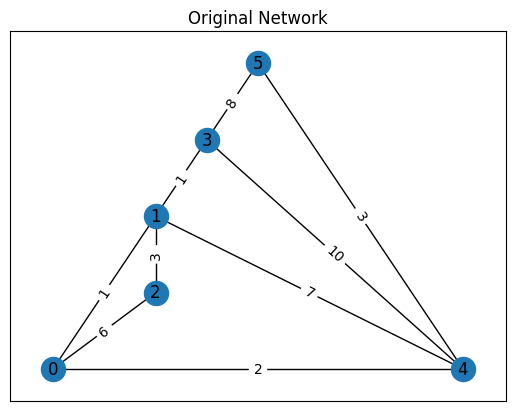

In [4]:
graph = Graph(6)
graph.addEdge(0, 2 ,6)
graph.addEdge(1, 3, 1)
graph.addEdge(1, 2, 3)
graph.addEdge(5, 3 ,8)
graph.addEdge(3, 4, 10)
graph.addEdge(1, 0, 1)
graph.addEdge(4, 5, 3)
graph.addEdge(4, 0, 2)
graph.addEdge(4, 1, 7)

v = GraphVisualizer()
v.addEdges(graph)
v.visualize("Original Network")

###  An example of `clustering_based_partitioning()`, where we perform for the graph until we have 3 partitions

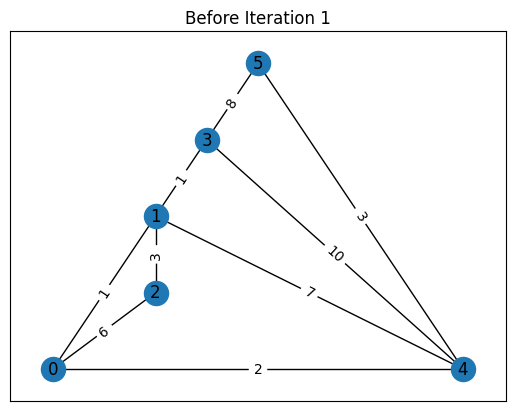

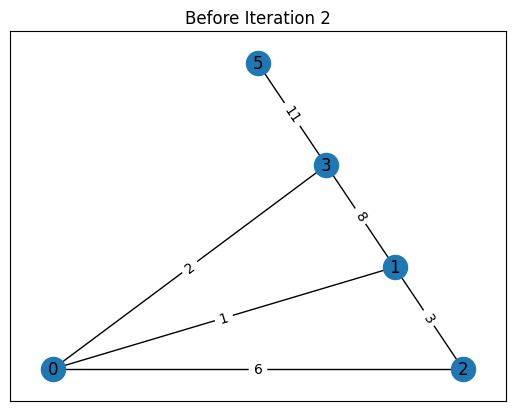

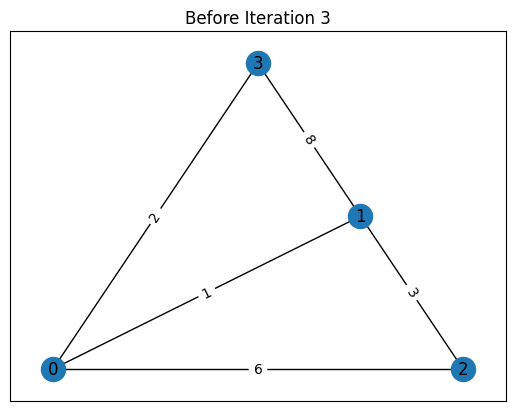

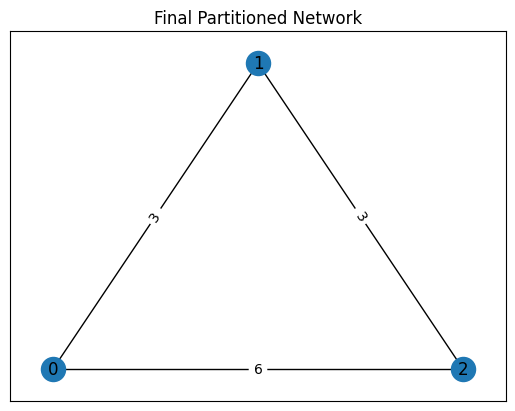

In [5]:
clustering_based_partitioning(graph, 3)